In [24]:
import os
import time
import shutil
import numpy as np
from glob import glob
from PIL import Image 
from sklearn.utils import shuffle
from tqdm import tqdm
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import utils

Create Training Directories for Dogs and Cats

In [3]:
pwd = %pwd
train_path = pwd + '/train/'
cats_path = train_path + 'cats/'
dogs_path = train_path + 'dogs/'

if not os.path.exists(cats_path):
    os.makedirs(cats_path)

if not os.path.exists(dogs_path):
    os.makedirs(dogs_path)
    
for f in os.listdir(train_path):
    if f.endswith('.jpg'):
        if f.startswith('cat'):
            shutil.move(train_path + f, cats_path + f)
        elif f.startswith('dog'):
            shutil.move(train_path + f, dogs_path + f)

Pre-process data

In [8]:
cat_files = sorted(glob(cats_path + 'cat*.jpg'))
dog_files = sorted(glob(dogs_path + 'dog*.jpg'))

print("Number of cat files: " + str(len(cat_files)))
print("Number of dog files: " + str(len(dog_files)))

n_files = len(cat_files) + len(dog_files)

size_image = 64

x_train = np.zeros((n_files, size_image, size_image, 3), dtype='float64')
y_train = np.zeros(n_files)
count = 0

print("Resizing images and loading training set ...")

for f in cat_files:
    img = Image.open(f)
    new_img = img.resize((size_image, size_image))
    x_train[count] = np.asarray(new_img, dtype='float64')
    y_train[count] = 0
    count = count + 1

for f in dog_files:
    img = Image.open(f)
    new_img = img.resize((size_image, size_image))
    x_train[count] = np.asarray(new_img, dtype='float64')
    y_train[count] = 1
    count = count + 1

print("... completed.")

Number of cat files: 12500
Number of dog files: 12500
Resizing images and loading training set ...
... completed.


Shuffle cats and dogs, and normalize

In [19]:
num_classes = 2

permutation = np.random.permutation(x_train.shape[0])
print("permutation: " + str(permutation))

x_train = x_train[permutation]
y_train = y_train[permutation]

x_train = x_train / 255.
y_train = utils.to_categorical(y_train, num_classes)

permutation: [18781   864  5298 ...,  8046 17069  1997]


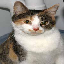

In [20]:
Image.fromarray(np.uint8(x_train[10001] * 255))

In [21]:
y_train[10001]

array([ 1.,  0.])

**Build Model**

This model resulted in good 83-85% validation and test accuracies

In [22]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
__________

Train Model

In [ ]:
batch_size = 64
epochs = 30

X_train = x_train[:22500]
Y_train = y_train[:22500]
X_valid = x_train[22500:23750]
Y_valid = y_train[22500:23750]
X_test = x_train[23750:25000]
Y_test = y_train[23750:25000]

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model_checkpoint = ModelCheckpoint(filepath='dogs_v_cats', verbose=1, save_best_only=True)

start = time.time()
model.fit(X_train, Y_train, validation_data=[X_valid, Y_valid], callbacks=[model_checkpoint, early_stopping], 
          epochs=epochs, batch_size=batch_size, verbose=2)
end = time.time()

print("Model took %0.2f seconds to train"%(end - start))

# Re-instantiate model to the best model saved
model = models.load_model('dogs_v_cats')

y_pred = model.predict(X_test, batch_size=batch_size)
score = model.evaluate(X_test, Y_test, verbose=0)

print(score)


In [10]:
test_path = pwd + '/test/'

testing_data = []
for image in tqdm(os.listdir(test_path)):
    path = os.path.join(test_path, image)
    img_num = image.split('.')[0]
    img = Image.open(path)
    new_img = img.resize((size_image, size_image))
    testing_data.append([np.asarray(new_img, dtype='float64'), img_num])

#    np.save('test_data.npy', testing_data)


100%|██████████| 12500/12500 [01:07<00:00, 183.97it/s]


In [16]:
with open('submission-file.csv', 'w') as f:
    f.write('id,label\n')

In [17]:
model = models.load_model('dogs_v_cats')

with open('submission-file.csv', 'a') as f:
    for data in tqdm(testing_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(1, size_image, size_image, 3)
        model_out = np.clip(model.predict([data])[0], 0.05, 0.95) #np.clip is used to keep the range of predictions between 0.05 and 0.95
        
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|██████████| 12500/12500 [00:38<00:00, 320.91it/s]


In [ ]:
model2 = Sequential()
model2.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.5))

model2.add(Flatten())
model2.add(BatchNormalization())

model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

In [26]:
batch_size = 64
epochs = 30

X_train = x_train[:22500]
Y_train = y_train[:22500]
X_valid = x_train[22500:23750]
Y_valid = y_train[22500:23750]
X_test = x_train[23750:25000]
Y_test = y_train[23750:25000]

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model_checkpoint = ModelCheckpoint(filepath='dogs_v_cats_dataaug', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.25,
                             horizontal_flip=True)

datagen.fit(X_train)

steps = len(X_train) / batch_size
start = time.time()
# fits the model on batches with real-time data augmentation:
model2.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=steps, epochs=epochs, 
                    validation_data=[X_valid, Y_valid], callbacks=[model_checkpoint, early_stopping],
                    verbose=2)
end = time.time()

print("Model took %0.2f seconds to train"%(end - start))

# Re-instantiate model to the best model saved
model2 = models.load_model('dogs_v_cats_dataaug')

y_pred = model2.predict(X_test, batch_size=batch_size)
score = model2.evaluate(X_test, Y_test, verbose=0)

print(score)

Epoch 1/30
Epoch 00000: val_loss improved from inf to 0.69699, saving model to dogs_v_cats
154s - loss: 0.8001 - acc: 0.5623 - val_loss: 0.6970 - val_acc: 0.5152
Epoch 2/30
Epoch 00001: val_loss did not improve
157s - loss: 0.6511 - acc: 0.6155 - val_loss: 0.7234 - val_acc: 0.4848
Epoch 3/30
Epoch 00002: val_loss did not improve
157s - loss: 0.6368 - acc: 0.6295 - val_loss: 0.8847 - val_acc: 0.5152
Epoch 4/30
Epoch 00003: val_loss did not improve
159s - loss: 0.6166 - acc: 0.6556 - val_loss: 0.9373 - val_acc: 0.5152
Model took 629.31 seconds to train
[0.71098765544891362, 0.47760000000000002]
